# RNA Folding LSTM Model

## Import and load data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
train = pd.read_csv('data/train_data_QUICK_START.csv')

## 2A3 Chemical Modifier

### Preprocessing

Separate data by the two chemical modifiers 2A3 and DMS

In [19]:
df_2A3 = train[train['experiment_type'] == '2A3_MaP']

In [20]:
# Get reactivity columns from 1 to 206
start_col = 4
end_col = 210

In [21]:
# Add padding to sequence such that they are all 457 in length
def pad_sequence(sequence, max_length=206, padding_value="Z"):
  # Calculate how many padding values are needed
  padding_length = max_length - len(sequence)
  # Create the padded sequence
  padded_sequence = list(sequence) + [padding_value] * padding_length
  return padded_sequence

def encode_nuc(nuc):
  nuc_map = {
      "A": [1,0,0,0,0],
      "C": [0,1,0,0,0],
      "G": [0,0,1,0,0],
      "U": [0,0,0,1,0],
      "Z": [0,0,0,0,1]
  }
  try:
      return nuc_map[nuc]
  except:
      print(f"Error at nucleotide {nuc}")

def encode_sequence(sequence):
  try:
    return [encode_nuc(s) for s in sequence]
  except:
    print(f"Error at sequence {sequence}")

Split RNA sequence into individual characters in a list

In [22]:
encoded_train = df_2A3.loc[:, ['sequence_id', 'sequence']]
encoded_train['padded_sequence'] = encoded_train['sequence'].apply(pad_sequence)
encoded_train

,sequence_id,sequence,padded_sequence
0,0000d87cab97,GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
2,0001ca9d21b0,GGGAACGACUCGAGUAGAGUCGAAAAGGUGGCCGGCAGAAUCGCGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
4,00021f968267,GGGAACGACUCGAGUAGAGUCGAAAACAUUGUUAAUGCCUAUAUUA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
6,00026ef17e1b,GGGAACGACUCGAGUAGAGUCGAAAAGGAGAUCGAAGACGACUUAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
8,000302908510,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGACUGACGAAGUCG...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
...,...,...,...
335606,fffe8ac231d6,GGGAACGACUCGAGUAGAGUCGAAAACAACGACGUUGCGACAACAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
335608,fffe94bea525,GGGAACGACUCGAGUAGAGUCGAAAACCUCGUCAUCUAAUUAGUGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
335610,fffee332db3a,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGAAGUAGAACUACC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
335612,ffff7786573c,GGGAACGACUCGAGUAGAGUCGAAAAGAAGACGUGACGAAAAGUCA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."


One hot encode sequences

In [23]:
encoded_train['encoded_sequence'] = encoded_train['padded_sequence'].apply(encode_sequence)
encoded_train

,sequence_id,sequence,padded_sequence,encoded_sequence
0,0000d87cab97,GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
2,0001ca9d21b0,GGGAACGACUCGAGUAGAGUCGAAAAGGUGGCCGGCAGAAUCGCGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
4,00021f968267,GGGAACGACUCGAGUAGAGUCGAAAACAUUGUUAAUGCCUAUAUUA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
6,00026ef17e1b,GGGAACGACUCGAGUAGAGUCGAAAAGGAGAUCGAAGACGACUUAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
8,000302908510,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGACUGACGAAGUCG...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
...,...,...,...,...
335606,fffe8ac231d6,GGGAACGACUCGAGUAGAGUCGAAAACAACGACGUUGCGACAACAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
335608,fffe94bea525,GGGAACGACUCGAGUAGAGUCGAAAACCUCGUCAUCUAAUUAGUGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
335610,fffee332db3a,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGAAGUAGAACUACC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
335612,ffff7786573c,GGGAACGACUCGAGUAGAGUCGAAAAGAAGACGUGACGAAAAGUCA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."


Get all encoded sequences

In [24]:
sequences = encoded_train['encoded_sequence']
sequences

0         [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
2         [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
4         [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
6         [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
8         [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
                                ...                        
335606    [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
335608    [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
335610    [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
335612    [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
335614    [[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0...
Name: encoded_sequence, Length: 167808, dtype: object

In [25]:
print(sequences.shape)
len(sequences[0])

(167808,)


206

In [26]:
reactivities = df_2A3.iloc[:, start_col:end_col]
reactivities.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Checking missing values

In [27]:
# Checking null values and filling in with 0
reactivities = df_2A3.iloc[:, start_col:end_col]
# print(dict(reactivities.isna().sum()))
print(reactivities.shape)
reactivities.fillna(0, inplace = True)

# Filling negative values in reactivities to 0
print((reactivities < 0).sum().sum())
reactivities[reactivities < 0] = 0
print((reactivities < 0).sum().sum())
reactivities

(167808, 206)
2715083
0


,reactivity_0001,reactivity_0002,reactivity_0003,reactivity_0004,reactivity_0005,reactivity_0006,reactivity_0007,reactivity_0008,reactivity_0009,reactivity_0010,...,reactivity_0197,reactivity_0198,reactivity_0199,reactivity_0200,reactivity_0201,reactivity_0202,reactivity_0203,reactivity_0204,reactivity_0205,reactivity_0206
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split Train/Test Data

In [28]:
X = sequences
Y = reactivities

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(134246,) (134246, 206)
(33562,) (33562, 206)


In [30]:
# Convert np arrays to tensors
X_train_array = np.array([np.array(seq) for seq in X_train])
X_test_array = np.array([np.array(seq) for seq in X_test])
X_train = tf.convert_to_tensor(X_train_array)
X_test = tf.convert_to_tensor(X_test_array)
Y_train = tf.convert_to_tensor(Y_train.values)
Y_test = tf.convert_to_tensor(Y_test.values)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(134246, 206, 5) (134246, 206)
(33562, 206, 5) (33562, 206)


### Training Model

In [31]:
# https://stackoverflow.com/questions/42665359/how-do-you-compute-accuracy-in-a-regression-model-after-rounding-predictions-to
from keras import backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [33]:
# Hyperparamters
sequence_length = 206
lstm_units = 64
batch_size = 100
num_features = 5 # Nucleotides: A, C, G, U, Z
num_target = 206
SEED = 101

In [35]:
model = Sequential()
model.add(LSTM(units=lstm_units, input_shape=(sequence_length, num_features), kernel_initializer=initializers.glorot_uniform(seed=SEED)))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(num_target))
model.summary()
optimizer = Adam(learning_rate=0.07)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[soft_acc])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 206)               26574     
                                                                 
Total params: 94030 (367.30 KB)
Trainable params: 94030 (367.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
1343/1343 [==============================] - 86s 64ms/step - loss: 0.4769 - soft_acc: 0.8282
Epoch 2/5
1343/1343 [==============================] - 86s 64ms/step - loss: 0.1748 - soft_acc: 0.8635
Epoch 3/5
1343/1343 [==============================] - 86s 64ms/step - loss: 0.1747 - soft_acc: 0.8634
Epoch 4/5
1343/1343 [==============================] - 86s 64ms/step - loss: 50.7561 - soft_acc: 0.6784
Epoch 5/5
1343/1343 [==============================] - 88s 65ms/step - loss: 0.2717 - soft_acc: 0.8142


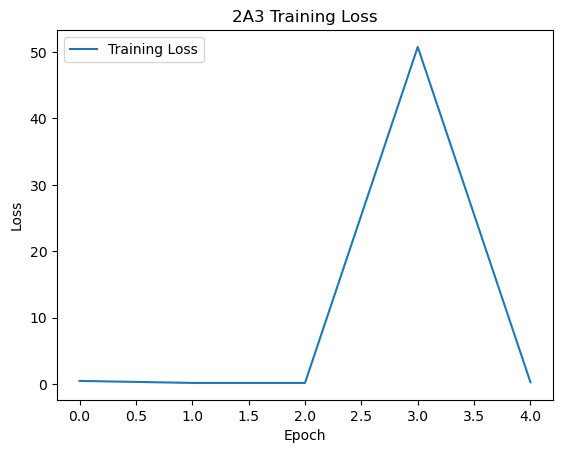

In [38]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('2A3 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
loss = model.evaluate(X_test, Y_test, batch_size=100)
print(f"Mean Absolute Error on Test Set: {loss}")

336/336 [==============================] - 8s 23ms/step - loss: 0.1802 - soft_acc: 0.8629
Mean Absolute Error on Test Set: [0.18022234737873077, 0.8629404902458191]


## DMS Chemical Modifier
Same process as with 2A3 chemical modifier

### Preprocessing

In [40]:
df_DMS = train[train['experiment_type'] == 'DMS_MaP']

In [41]:
start_col = 4
end_col = 210

In [42]:
# Split RNA sequence into individual characters in a list
encoded_train = df_DMS.loc[:, ['sequence_id', 'sequence']]
encoded_train['padded_sequence'] = encoded_train['sequence'].apply(pad_sequence)
encoded_train

,sequence_id,sequence,padded_sequence
1,0000d87cab97,GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
3,0001ca9d21b0,GGGAACGACUCGAGUAGAGUCGAAAAGGUGGCCGGCAGAAUCGCGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
5,00021f968267,GGGAACGACUCGAGUAGAGUCGAAAACAUUGUUAAUGCCUAUAUUA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
7,00026ef17e1b,GGGAACGACUCGAGUAGAGUCGAAAAGGAGAUCGAAGACGACUUAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
9,000302908510,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGACUGACGAAGUCG...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
...,...,...,...
335607,fffe8ac231d6,GGGAACGACUCGAGUAGAGUCGAAAACAACGACGUUGCGACAACAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
335609,fffe94bea525,GGGAACGACUCGAGUAGAGUCGAAAACCUCGUCAUCUAAUUAGUGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
335611,fffee332db3a,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGAAGUAGAACUACC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."
335613,ffff7786573c,GGGAACGACUCGAGUAGAGUCGAAAAGAAGACGUGACGAAAAGUCA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ..."


In [43]:
# One hot encode sequences
encoded_train['encoded_sequence'] = encoded_train['padded_sequence'].apply(encode_sequence)
encoded_train

,sequence_id,sequence,padded_sequence,encoded_sequence
1,0000d87cab97,GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
3,0001ca9d21b0,GGGAACGACUCGAGUAGAGUCGAAAAGGUGGCCGGCAGAAUCGCGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
5,00021f968267,GGGAACGACUCGAGUAGAGUCGAAAACAUUGUUAAUGCCUAUAUUA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
7,00026ef17e1b,GGGAACGACUCGAGUAGAGUCGAAAAGGAGAUCGAAGACGACUUAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
9,000302908510,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGACUGACGAAGUCG...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
...,...,...,...,...
335607,fffe8ac231d6,GGGAACGACUCGAGUAGAGUCGAAAACAACGACGUUGCGACAACAC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
335609,fffe94bea525,GGGAACGACUCGAGUAGAGUCGAAAACCUCGUCAUCUAAUUAGUGA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
335611,fffee332db3a,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGAAGUAGAACUACC...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."
335613,ffff7786573c,GGGAACGACUCGAGUAGAGUCGAAAAGAAGACGUGACGAAAAGUCA...,"[G, G, G, A, A, C, G, A, C, U, C, G, A, G, U, ...","[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0..."


In [44]:
# Get all encoded sequences
sequences = encoded_train['encoded_sequence']

In [45]:
print(sequences.shape)
len(sequences.iloc[0])

(167808,)


206

In [46]:
# Checking null values and filling in with 0
reactivities = df_DMS.iloc[:, start_col:end_col]
# print(dict(reactivities.isna().sum()))
print(reactivities.shape)
reactivities.fillna(0, inplace = True)

# Filling negative values in reactivities to 0
print((reactivities < 0).sum().sum())
reactivities[reactivities < 0] = 0
print((reactivities < 0).sum().sum())
reactivities

reactivities

(167808, 206)
2500318
0


,reactivity_0001,reactivity_0002,reactivity_0003,reactivity_0004,reactivity_0005,reactivity_0006,reactivity_0007,reactivity_0008,reactivity_0009,reactivity_0010,...,reactivity_0197,reactivity_0198,reactivity_0199,reactivity_0200,reactivity_0201,reactivity_0202,reactivity_0203,reactivity_0204,reactivity_0205,reactivity_0206
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split Train/Test Data

In [47]:
X = sequences
Y = reactivities

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1234)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(134246,) (134246, 206)
(33562,) (33562, 206)


In [49]:
# Convert np arrays to tensors
X_train_array = np.array([np.array(seq) for seq in X_train])
X_test_array = np.array([np.array(seq) for seq in X_test])
X_train = tf.convert_to_tensor(X_train_array)
X_test = tf.convert_to_tensor(X_test_array)
Y_train = tf.convert_to_tensor(Y_train.values)
Y_test = tf.convert_to_tensor(Y_test.values)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(134246, 206, 5) (134246, 206)
(33562, 206, 5) (33562, 206)


## Training Model

In [50]:
# https://stackoverflow.com/questions/42665359/how-do-you-compute-accuracy-in-a-regression-model-after-rounding-predictions-to
from keras import backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [51]:
# Hyperparamters
sequence_length = 206
lstm_units = 64
batch_size = 200
num_features = 5 # Nucleotides: A, C, G, U, Z
num_target = 206

In [52]:
model = Sequential()
model.add(LSTM(units=lstm_units, input_shape=(sequence_length, num_features)))
# model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(num_target))
model.summary()
optimizer = Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[soft_acc])
history = model.fit(X_train, Y_train, epochs=5, batch_size=batch_size)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17920     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 256)               16640     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 206)               26574     
                                                                 
Total params: 94030 (367.30 KB)
Trainable params: 94030 (367.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
672/67

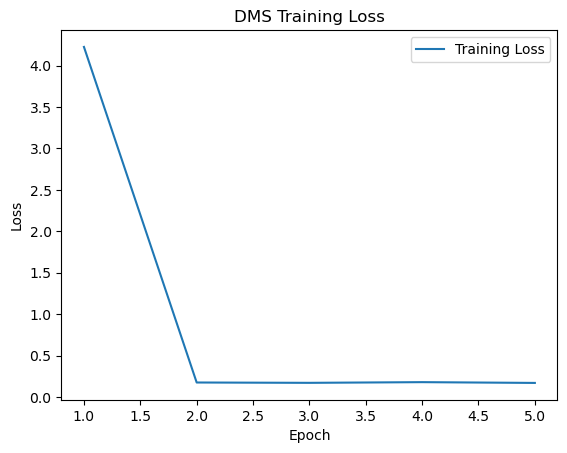

In [53]:
plt.plot(range(1, 6), history.history['loss'], label='Training Loss')
plt.title('DMS Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
loss = model.evaluate(X_test, Y_test)
print(f"Mean Absolute Error on Test Set: {loss}")

1049/1049 [==============================] - 8s 8ms/step - loss: 0.1684 - soft_acc: 0.8788
Mean Absolute Error on Test Set: [0.1684291958808899, 0.8787556886672974]
